# Decision Tree

The Decision Tree algorithm is a supervised machine learning algorithm that takes place in two steps: first, starting with the single root node, if all, or an acceptable number, of records in the node belong to a single class or all have the same attributes, the node becomes a leaf node; if the node does not become a leaf node, an attribute and test condition are chosen to split the node into child nodes. These two steps are recursively applied to create the final decision tree. It was determined that the decision tree classifier could be a suitable option for our data because it is computationally inexpensive, easy to interpret, and is resilient to noise, which our data has some of because it is such a small dataset. When running it, we looked for possible data fragmentation, or leaves with too few values, as that might be more likely to happen with such a small number of records. Further, we chose the minimum number of values in a leaf as one of the hyperparameters to watch this. 

In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
import math

import sklearn as sk
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

import warnings
warnings.simplefilter("ignore")
import time

%matplotlib inline

First load the cleaned and imputed dataset from utils.py and display the top of the class labels and features. 

In [14]:
from utils import intake_data
data_X, data_Y = intake_data()
print(data_Y.head())
data_X.head()

TEST
looks like imblearn isn't installed! skipping upsampling: No module named 'imblearn'
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: death, dtype: float64


,age,sex,Alb,PLT,WBC,CRP,APACHE II,SOFA,McCabe,PaO2/FiO2,LDH,CT score,PEEP,PIP,TV,DARDS = 1
0,79.0,0,2.3,10.8,4000.0,17.8,24.0,8.0,1.0,108.0,339.0,191.6,24.0,25.948052,428.05036,0.0
1,83.0,0,4.4,13.5,10200.0,8.9,16.0,6.0,1.0,78.0,385.0,213.3,5.0,10.000000,360.00000,0.0
2,70.0,0,2.7,10.8,5300.0,25.3,22.0,7.0,1.0,70.9,461.0,221.7,18.0,24.000000,525.00000,0.0
3,61.0,0,3.3,8.8,1800.0,22.2,26.0,7.0,1.0,59.2,227.0,211.6,10.0,24.000000,480.00000,0.0
4,81.0,0,3.1,26.2,10600.0,17.0,19.0,4.0,1.0,83.6,680.0,234.9,5.0,10.000000,625.00000,0.0


Second, perform a nested cross-validation to determine the accuracy of a Decision Tree classifier on the dataset. The hyperparamters max_depth, max_features, min_samples_leaf, and criterion were chosen for this validation. The range of tested hyperparameter values was based on typical tested values, and then the ranges were reduced to accomodate the smaller number of records. If, after running the cross-validation with the chosen range of hyperparameter values, the maximum or minimum in the range was chosen, the range was extended, the cross-validation re-run, and the proecess repeated until the chosen values consistently fell on the inside of the range. 

In [16]:
# run a nested cross-validation 
dt = DecisionTreeClassifier()
params = {"max_depth":[1,2,3,4,5,6], "max_features":[2,4,6,8,10,12,14,16], 
          "min_samples_leaf":[2,4,6,8,10,12,14,16,18,20,22,24], "criterion":['gini', 'entropy']} 
clf_grid_pipe =sk.model_selection.GridSearchCV(dt, param_grid = params, scoring = "accuracy", cv = 10)
clf_grid_pipe.fit(data_X, data_Y)
print('Best score:', round(clf_grid_pipe.best_score_, 4))
print('Best parameters:\n',
      'max depth:', clf_grid_pipe.best_params_['max_depth'],
      '; max features:', clf_grid_pipe.best_params_['max_features'],
      '; min samples leaf:', clf_grid_pipe.best_params_['min_samples_leaf'], 
      '; criterion:', clf_grid_pipe.best_params_['criterion'])

pred_Y = sk.model_selection.cross_val_predict(clf_grid_pipe, data_X, data_Y, cv = 10)

print('Accuracy: '+ str(round(accuracy_score(data_Y, pred_Y), 2)*100) + '%')

Best score: 0.7202
Best parameters:
 max depth: 4 ; max features: 12 ; min samples leaf: 14 ; criterion: entropy
Accuracy: 61.0%


Next, develop the classification report and a confusion matrix for the classifier. 

              precision    recall  f1-score   support

           0       0.68      0.75      0.71       127
           1       0.41      0.33      0.37        66

    accuracy                           0.61       193
   macro avg       0.55      0.54      0.54       193
weighted avg       0.59      0.61      0.60       193



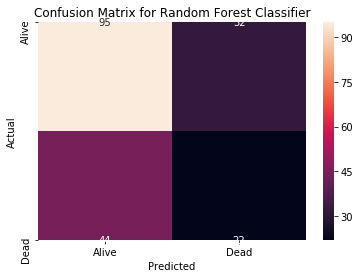

In [26]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sn

print(classification_report(data_Y, pred_Y, labels = [0,1]))

#Create a confusion matrix
data = {'Actual': data_Y, 'Predicted': pred_Y}
df = pd.DataFrame(data, columns=['Actual', 'Predicted'])
df['Predicted'].replace(0, 'Alive', inplace=True)
df['Predicted'].replace(1, 'Dead', inplace=True)
df['Actual'].replace(0, 'Alive', inplace=True)
df['Actual'].replace(1, 'Dead', inplace=True)
cm = pd.crosstab(df['Actual'], df['Predicted'], rownames=['Actual'], colnames=['Predicted'])                                    
#Print a formatted confusion matrix using a heatmap
sn.heatmap(cm, annot=True)
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

#print("confusion matrix:\n", confusion_matrix(data_Y, pred_Y))

Finally, run the Decision Tree Classifier on the whole dataset with the chosen best hyperparamters. 

[Text(178.56, 195.696, 'X[11] <= 210.75\nentropy = 0.927\nsamples = 193\nvalue = [127, 66]'), Text(89.28, 152.208, 'X[4] <= 4550.0\nentropy = 0.695\nsamples = 91\nvalue = [74, 17]'), Text(44.64, 108.72, 'X[10] <= 280.5\nentropy = 0.981\nsamples = 31\nvalue = [18, 13]'), Text(22.32, 65.232, 'entropy = 0.592\nsamples = 14\nvalue = [12, 2]'), Text(66.96000000000001, 65.232, 'entropy = 0.937\nsamples = 17\nvalue = [6, 11]'), Text(133.92000000000002, 108.72, 'X[14] <= 367.5\nentropy = 0.353\nsamples = 60\nvalue = [56, 4]'), Text(111.6, 65.232, 'entropy = 0.787\nsamples = 17\nvalue = [13, 4]'), Text(156.24, 65.232, 'entropy = 0.0\nsamples = 43\nvalue = [43, 0]'), Text(267.84000000000003, 152.208, 'X[15] <= 0.5\nentropy = 0.999\nsamples = 102\nvalue = [53, 49]'), Text(245.52, 108.72, 'X[4] <= 9900.0\nentropy = 0.989\nsamples = 80\nvalue = [35, 45]'), Text(200.88, 65.232, 'X[4] <= 6850.0\nentropy = 0.974\nsamples = 32\nvalue = [19, 13]'), Text(178.56, 21.744, 'entropy = 0.94\nsamples = 14\nval

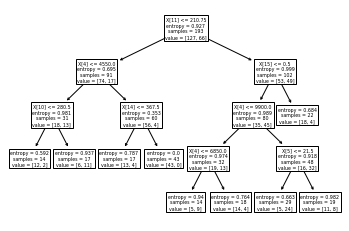

In [25]:
clf = DecisionTreeClassifier(criterion = "entropy", 
                            max_depth = 4, 
                            max_features = 12, 
                            min_samples_leaf = 14)
print(tree.plot_tree(clf.fit(data_X, data_Y)))